# Testing of Quality Eduaction Area

In [17]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Load the geographic data
gdf = gpd.read_file("/Users/jichunzhao/Documents/qtm2025spring/qtm550spring2025_QSP/" \
"LIHTC-Project/data/raw/shapefiles/APSBoundaries.json")

# Check Coordinate System
gdf.crs

<Projected CRS: EPSG:2240>
Name: NAD83 / Georgia West (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Georgia - counties of Baker; Banks; Barrow; Bartow; Ben Hill; Berrien; Bibb; Bleckley; Brooks; Butts; Calhoun; Carroll; Catoosa; Chattahoochee; Chattooga; Cherokee; Clarke; Clay; Clayton; Cobb; Colquitt; Cook; Coweta; Crawford; Crisp; Dade; Dawson; De Kalb; Decatur; Dooly; Dougherty; Douglas; Early; Fannin; Fayette; Floyd; Forsyth; Fulton; Gilmer; Gordon; Grady; Gwinnett; Habersham; Hall; Haralson; Harris; Heard; Henry; Houston; Irwin; Jackson; Jasper; Jones; Lamar; Lee; Lowndes; Lumpkin; Macon; Marion; Meriwether; Miller; Mitchell; Monroe; Morgan; Murray; Muscogee; Newton; Oconee; Paulding; Peach; Pickens; Pike; Polk; Pulaski; Putnam; Quitman; Rabun; Randolph; Rockdale; Schley; Seminole; Spalding; Stewart; Sumter; Talbot; Taylor; Terrell; Thomas; Tift; Towns; Troup; Turner; Twiggs; Union

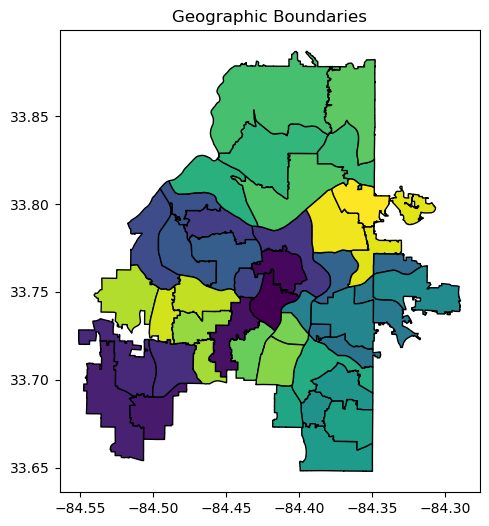

In [6]:
# Connvert to WGS84(EPSG:4326)
gdf = gdf.to_crs(epsg=4326)

# Plot the data
gdf.plot(figsize=(10, 6), edgecolor="black", cmap="viridis")
plt.title("Geographic Boundaries")
plt.show()

In [7]:
from shapely.geometry import Point
# Define a random point (Longitude, Latitude within the map bounds)
random_point = Point(-84.44, 33.76)  # Example: A point in Atlanta

# Find the subdistrict that contains the random point
gdf[gdf.contains(random_point)]

,OBJECTID,SchCode,Elementary,Middle,High,SchCode_MS,SchCode_HS,Area,Shape__Are,Shape__Len,Shape__Area,Shape__Length,geometry
9,10,105,F.L. Stanton,John Lewis Invictus Academy,Douglass,363,43,1.059238,2.952985e+07,24379.426635,2.952985e+07,24379.426635,"POLYGON ((-84.43197 33.76255, -84.43169 33.762..."


In [5]:
# import pandas as pd

# Convert to Pandas DataFrame (drop geometry)
# df = pd.DataFrame(gdf.drop(columns=["geometry"]))

In [16]:
matching_area = gdf[gdf.contains(random_point)]

from thefuzz import process

# Load school data
school_df = pd.read_excel(
    "/Users/jichunzhao/Documents/qtm2025spring/qtm550spring2025_QSP/" \
    "LIHTC-Project/data/raw/scoring_indicators/2024option_c_-_scoring_data_4.xlsx",
    sheet_name="Option C-Scores Eligibility",
    skiprows=[0],  # Skip the first row (index 0)
    header=1       # Use the new first row (original second row) as column names
)

In [7]:
print(school_df.columns)

Index([                           'Unnamed: 0',
                                   'System ID',
                                 'System Name',
                                   'School ID',
                                'School Name ',
                               'Grade Cluster',
                                          2015,
                                          2016,
                                          2017,
                                          2018,
                                          2019,
                                    '15 to 16',
                                    '16 to 17',
                                    '18 to 19',
                                 'YoY Average',
                        'Average is positive?',
                               'Average score',
       'CCRPI Score Data Availability (years)',
                  'Applicable 25th Percentile',
                'Average Score is in Top 75%?',
                                 'Unname

In [8]:
import re
from thefuzz import process, fuzz

def preprocess_school_name(name):
    # Lowercase, remove punctuation/initials, and strip suffixes
    name = re.sub(r'[^\w\s]', '', str(name).lower())
    name = re.sub(r'\b\w\s?\.?\s?', '', name)  # Remove initials like "Dr.", "J."
    suffixes = ["elementary", "middle", "high", "school", "academy", "jr", "sr", "dr"]
    tokens = [token for token in name.split() if token not in suffixes]
    return " ".join(tokens).strip()

def find_best_match(school_name, school_df, school_type):
    # Map school type to grade cluster (E/M/H)
    grade_cluster = {"elementary": "E", "middle": "M", "high": "H"}.get(school_type.lower())
    
    # Filter schools by grade cluster
    filtered_df = school_df[school_df["Grade Cluster"] == grade_cluster]
    if filtered_df.empty:
        return None
    
    # Preprocess names
    cleaned_input = preprocess_school_name(school_name)
    cleaned_names = filtered_df["School Name "].apply(preprocess_school_name).tolist()
    
    # Fuzzy match with token_set_ratio
    best_match, score = process.extractOne(
        cleaned_input,
        cleaned_names,
        scorer=fuzz.token_set_ratio
    )
    
    # Return match if score is high enough
    if score > 80:
        return filtered_df[filtered_df["School Name "].apply(preprocess_school_name) == best_match].iloc[0]
    return None

if not matching_area.empty:
    elementary_school = matching_area.iloc[0]["Elementary"]
    middle_school = matching_area.iloc[0]["Middle"]
    high_school = matching_area.iloc[0]["High"]

    print(f"Searching for:\n- Elementary: {elementary_school}\n- Middle: {middle_school}\n- High: {high_school}\n")

    # Find matches with school type filtering
    best_elementary = find_best_match(elementary_school, school_df, "elementary")
    best_middle = find_best_match(middle_school, school_df, "middle")
    best_high = find_best_match(high_school, school_df, "high")

    # Display results
    print("\nBest Matches:")
    for category, match in zip(["Elementary", "Middle", "High"], [best_elementary, best_middle, best_high]):
        if match is not None:
            print(f"{category} School Match:")
            print(f"- Full Name: {match['School Name ']}")
            print(f"- System Name: {match['System Name']}")
            print(f"- Grade Cluster: {match['Grade Cluster']}\n")
        else:
            print(f"No strong {category} school match found\n")

Searching for:
- Elementary: F.L. Stanton
- Middle: John Lewis Invictus Academy
- High: Douglass


Best Matches:
Elementary School Match:
- Full Name: F. L. Stanton Elementary School
- System Name: Atlanta Public Schools
- Grade Cluster: E

Middle School Match:
- Full Name: John Lewis Invictus Academy
- System Name: Atlanta Public Schools
- Grade Cluster: M

High School Match:
- Full Name: Douglass High School
- System Name: Atlanta Public Schools
- Grade Cluster: H



In [9]:
best_elementary

Unnamed: 0                                                           NaN
System ID                                                            761
System Name                                       Atlanta Public Schools
School ID                                                           5566
School Name                              F. L. Stanton Elementary School
Grade Cluster                                                          E
2015                                                                48.5
2016                                                                51.1
2017                                                                51.6
2018                                                                70.9
2019                                                                68.0
15 to 16                                                        0.053608
16 to 17                                                        0.009785
18 to 19                                           

In [15]:
def qualifies_by_A(school, state_avg_by_year):
    """
    Qualifies under criteria A:
    - Uses CCRPI scores for 2018 and 2019 (if available)
    - Compares average to state average
    """
    years = [y for y in [2018, 2019] if y in state_avg_by_year and y in school.index and not pd.isna(school[y])]
    if not years:
        return False
    school_avg = school[years].mean()
    state_avg = sum(state_avg_by_year[y] for y in years) / len(years)
    return school_avg > state_avg


In [19]:
def qualifies_by_B(school):
    """
    Placeholder: Beating the Odds flag must be added to dataset to enable this.
    """
    return school.get('Beating the Odds', False)

def qualifies_by_C(school):
    """
    Qualifies under criteria C:
    - Positive average YoY CCRPI change (excluding 2017–18)
    - Average score >= 25th percentile threshold
    """
    try:
        return (
            float(school['YoY Average']) > 0 and
            float(school['Average score']) >= float(school['Applicable 25th Percentile'])
        )
    except (ValueError, TypeError, KeyError):
        return False

In [16]:
def grade_cluster_to_grades(cluster):
    """
    Converts Grade Cluster (E, M, H) into grade numbers (K=0, ..., 12)
    """
    mapping = {
        'E': list(range(0, 6)),   # Elementary: K–5
        'M': list(range(6, 9)),   # Middle: 6–8
        'H': list(range(9, 13)),  # High: 9–12
    }
    return mapping.get(str(cluster).strip().upper(), [])

In [ ]:
condition_a = qualifies_by_A(best_elementary, {2018: 77.8, 2019: 79.9})
# condition_b = qualifies_by_B(best_elementary)

False

In [ ]:
condition_c = qualifies_by_C(best_elementary)

False

In [35]:
def calculate_quality_education_points_by_school_set(best_elementary, best_middle, best_high, state_avg_by_year):
    """
    Evaluates best school in each cluster (elementary, middle, high).
    Each input is a single school row (Pandas Series) that includes 'Grade Cluster' and 'tenancy_type'.
    Returns total points (0–3) based on valid qualified grades.
    """
    total_qualified_grades = set()

    for school in [best_elementary, best_middle, best_high]:
        if school is None or not isinstance(school, pd.Series):
            continue
        if (
            qualifies_by_A(school, state_avg_by_year) or
            qualifies_by_B(school) or
            qualifies_by_C(school)
        ):
            grades = grade_cluster_to_grades(school.get('Grade Cluster', ''))
            total_qualified_grades.update(grades)
            tenancy_type = school.get('tenancy_type', '').lower()

    grade_count = len(total_qualified_grades)
    
    # Scoring logic based on tenancy type
    if grade_count == 0:
        return 0
    elif grade_count == 3:
        return 1
    elif grade_count == 7:
        return 1.5
    elif grade_count == 13:
        return 3 if tenancy_type in ['family'] else 2
    elif 3 < grade_count < 7:
        return 1
    elif 7 < grade_count < 13:
        return 1.5
    return 0


In [36]:
calculate_quality_education_points_by_school_set(best_elementary, best_middle, best_high, {2018: 77.8, 2019: 79.9})

0

In [ ]:
###### Merged version
"""
def calculate_quality_education_points_by_school_set(best_elementary, best_middle, best_high, state_avg_by_year):
    
    #Evaluates best school in each cluster (elementary, middle, high).
    #Each input is a single school row (Pandas Series) that includes 'Grade Cluster' and 'tenancy_type'.
    #Returns total points (0–3) based on valid qualified grades.
    
    def qualifies_by_A(school, state_avg_by_year):
        years = [y for y in [2018, 2019] if y in state_avg_by_year and y in school.index and not pd.isna(school[y])]
        if not years:
            return False
        school_avg = school[years].mean()
        state_avg = sum(state_avg_by_year[y] for y in years) / len(years)
        return school_avg > state_avg

    def qualifies_by_B(school):
        return school.get('Beating the Odds', False)

    def qualifies_by_C(school):
        try:
            return (
                float(school['YoY Average']) > 0 and
                float(school['Average score']) >= float(school['Applicable 25th Percentile'])
            )
        except (ValueError, TypeError, KeyError):
            return False

    def grade_cluster_to_grades(cluster):
        mapping = {
            'E': list(range(0, 6)),   # Elementary: K–5
            'M': list(range(6, 9)),   # Middle: 6–8
            'H': list(range(9, 13)),  # High: 9–12
        }
        return mapping.get(str(cluster).strip().upper(), [])

    total_qualified_grades = set()

    for school in [best_elementary, best_middle, best_high]:
        if school is None or not isinstance(school, pd.Series):
            continue
        if (
            qualifies_by_A(school, state_avg_by_year) or
            qualifies_by_B(school) or
            qualifies_by_C(school)
        ):
            grades = grade_cluster_to_grades(school.get('Grade Cluster', ''))
            total_qualified_grades.update(grades)
            tenancy_type = school.get('tenancy_type', '').lower()

    grade_count = len(total_qualified_grades)

    # Scoring logic based on tenancy type
    if grade_count == 0:
        return 0
    elif grade_count == 3:
        return 1
    elif grade_count == 7:
        return 1.5
    elif grade_count == 13:
        return 3 if tenancy_type in ['elderly', 'family'] else 2
    elif 3 < grade_count < 7:
        return 1
    elif 7 < grade_count < 13:
        return 1.5
    return 0
 """